In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from prophet import Prophet

In [3]:
df = pd.read_csv('data/Italy gas consumption-1.csv', 
                   index_col=['Date'], parse_dates=['Date'], dayfirst=True)

In [4]:
df.head()

,Consumption,Mean temperature
Date,,
2016-01-01,233.59,5.86
2016-01-02,250.99,6.87
2016-01-03,242.07,7.13
2016-01-04,286.05,7.28
2016-01-05,284.71,8.22


In [7]:
df_prophet = df.reset_index()
df_prophet.columns = ['ds', 'y', 'z']

In [8]:
df_prophet

,ds,y,z
0,2016-01-01,233.59,5.86
1,2016-01-02,250.99,6.87
2,2016-01-03,242.07,7.13
3,2016-01-04,286.05,7.28
4,2016-01-05,284.71,8.22
...,...,...,...
1822,2020-12-27,239.09,4.24
1823,2020-12-28,278.86,6.93
1824,2020-12-29,279.21,7.73
1825,2020-12-30,272.27,6.56


In [9]:
model = Prophet(weekly_seasonality=True, daily_seasonality=True)
model.add_country_holidays(country_name='IT')
model.add_regressor('z')
model.fit(df_prophet)

21:40:00 - cmdstanpy - INFO - Chain [1] start processing
21:40:01 - cmdstanpy - INFO - Chain [1] done processing


In [10]:
future = df_prophet[['ds', 'z']]
forecast = model.predict(future)

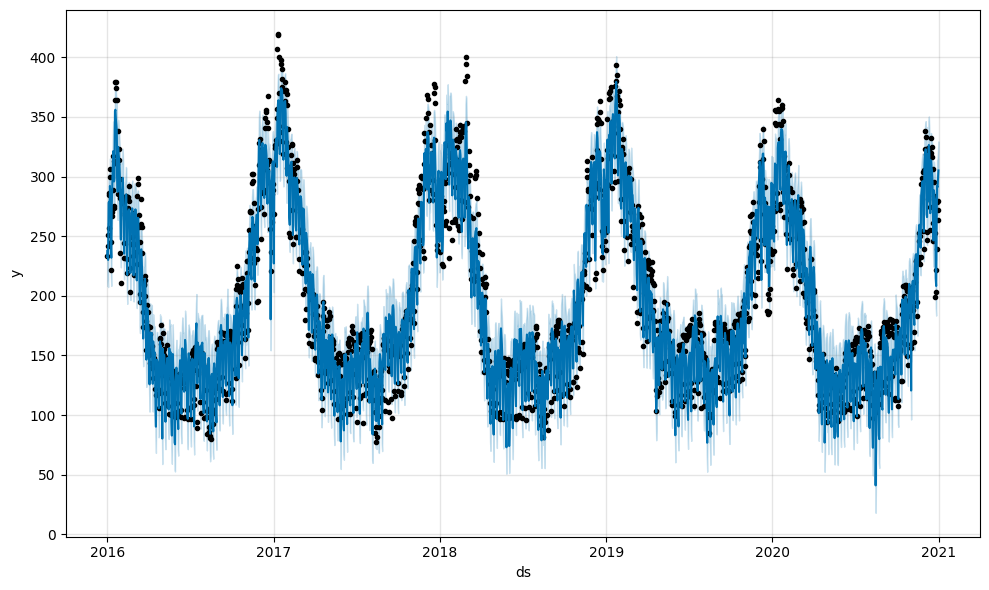

In [11]:
model.plot(forecast)
plt.show()

In [275]:
y_hat = forecast['yhat'][-366:].values
y_old = df['Consumption'][-366:].values
sum(2 * np.abs((y_hat - y_old)) / (np.abs(y_hat) + np.abs(y_old))) * 100 / 366

7.771726578079041

In [276]:
resids = df_prophet['y'][:df_prophet.shape[0]-366]-forecast['yhat'][:df_prophet.shape[0]-366]

<AxesSubplot: >

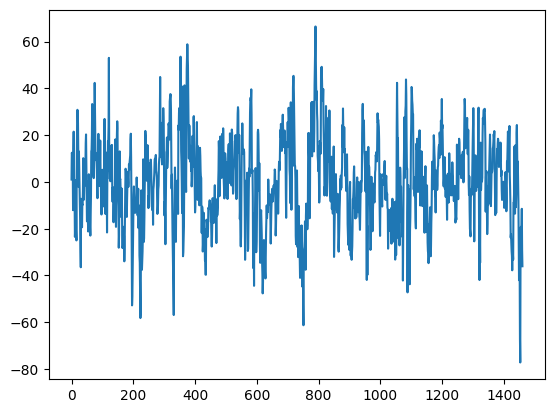

In [277]:
resids.plot()

In [278]:
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller

In [279]:
y_transformation = pd.DataFrame(resids.values, columns=['initial'])

In [280]:
print("Критерий Дики-Фуллера для исходного ряда с 1975 года: p=%f" % adfuller(y_transformation['initial'])[1])

Критерий Дики-Фуллера для исходного ряда с 1975 года: p=0.000000


In [281]:
d=0

In [282]:
model1 = SARIMAX(y_transformation['initial'],
                order=(1, 0, 1),
                seasonal_order=(2, 0, 1, 7)).fit()

In [283]:
model2 = SARIMAX(y_transformation['initial'],
                order=(1, 0, 1),
                seasonal_order=(1, 0, 1, 30)).fit()

In [284]:
model3 = SARIMAX(y_transformation['initial'],
                order=(1, 0, 3),
                seasonal_order=(2, 0, 3, 7)).fit()

c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [285]:
model4 = SARIMAX(y_transformation['initial'],
                order=(1, 0, 2),
                seasonal_order=(2, 0, 1, 30)).fit()

In [286]:
print(model1.aic, model2.aic, model3.aic, model4.aic)

10976.966817400924 11057.868711985198 10979.045821682994 11042.471875167941


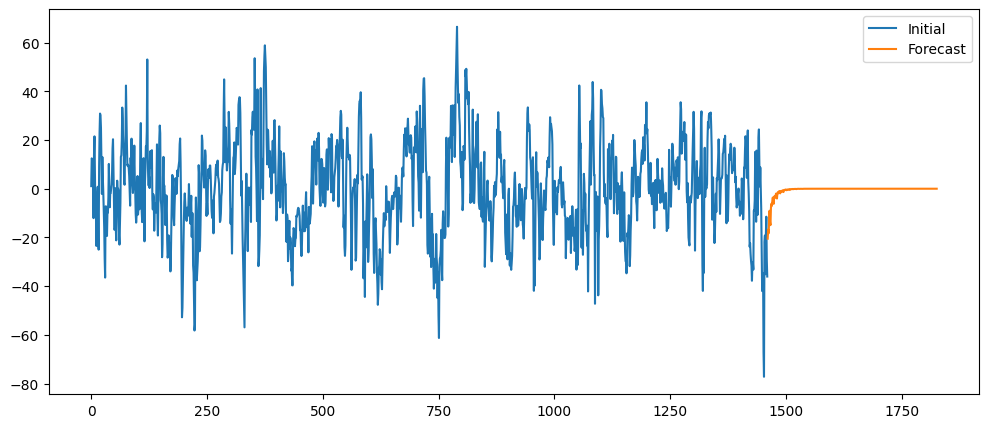

In [287]:
y_transformation['initial'].plot(figsize=(12,5))
model3.forecast(366).plot()
plt.legend(['Initial', 'Forecast'])
plt.show()

In [288]:
forecast1 = model3.forecast(366)

In [289]:
forecast1+forecast['yhat'][-366:]

1461    227.625169
1462    276.645996
1463    267.321638
1464    235.001351
1465    236.419327
           ...    
1822    260.310257
1823    291.978402
1824    291.161079
1825    298.716149
1826    305.151081
Length: 366, dtype: float64

<AxesSubplot: >

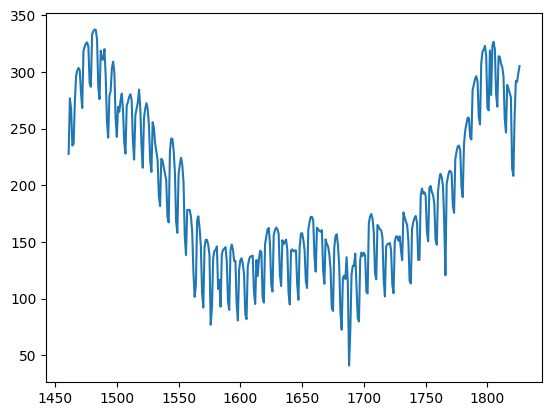

In [290]:
(forecast1+forecast['yhat'][-366:]).plot()

In [291]:
y_hat_new = (forecast1+forecast['yhat'][-366:]).values
y_old = df['Consumption'][-366:].values
sum(2 * np.abs((y_hat_new - y_old)) / (np.abs(y_hat_new) + np.abs(y_old))) * 100 / 366

7.817073946305925

In [295]:
resids = df['Consumption'][:-366].values-forecast['yhat'][:-366].values

In [296]:
resids

array([  1.05803185,  12.47739825,  11.99670353, ..., -11.4909176 ,
       -29.13129542, -36.05563608])

In [297]:
resids = pd.DataFrame(resids)
resids.index = df.index[:-366]

In [298]:
resids

,0
Date,
2016-01-01,1.058032
2016-01-02,12.477398
2016-01-03,11.996704
2016-01-04,8.024605
2016-01-05,5.759648
...,...
2019-12-27,-35.116441
2019-12-28,-19.283090
2019-12-29,-11.490918


In [299]:
week_resids = pd.DataFrame(resids.resample('W').mean())[:-1]

In [300]:
week_resids

,0
Date,
2016-01-03,8.510711
2016-01-10,4.560399
2016-01-17,-14.188510
2016-01-24,17.983820
2016-01-31,-10.672960
...,...
2019-12-01,-31.394853
2019-12-08,0.697797
2019-12-15,5.013585


In [302]:
print("Критерий Дики-Фуллера для исходного ряда с 1975 года: p=%f" % adfuller(week_resids[0])[1])

Критерий Дики-Фуллера для исходного ряда с 1975 года: p=0.000000


In [304]:
model_week = SARIMAX(week_resids[0],
                order=(2, 0, 1),
                seasonal_order=(1, 0, 1, 4)).fit()

c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


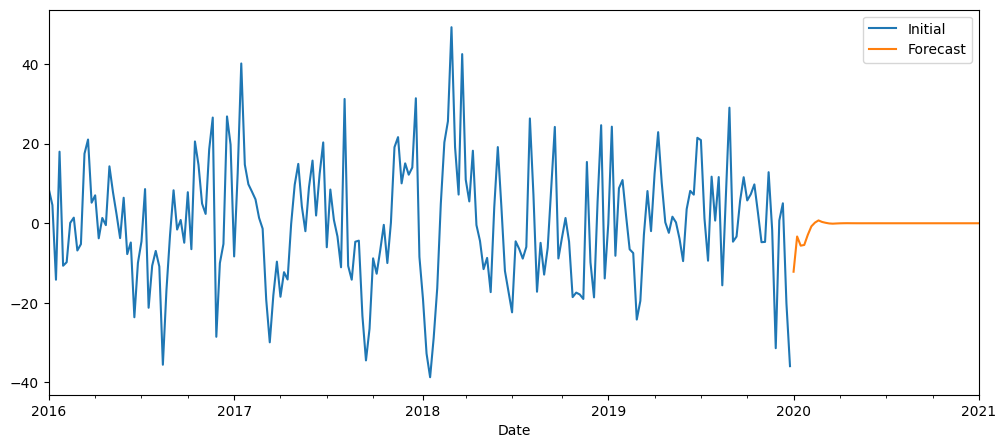

In [305]:
week_resids[0].plot(figsize=(12,5))
model_week.forecast(53).plot()
plt.legend(['Initial', 'Forecast'])
plt.show()

In [306]:
model_week.forecast(53)

2020-01-05   -1.217714e+01
2020-01-12   -3.322437e+00
2020-01-19   -5.631611e+00
2020-01-26   -5.450309e+00
2020-02-02   -2.904751e+00
2020-02-09   -7.775003e-01
2020-02-16    1.581462e-01
2020-02-23    7.116188e-01
2020-03-01    3.291822e-01
2020-03-08    1.160659e-01
2020-03-15   -4.665642e-02
2020-03-22   -1.057004e-01
2020-03-29   -5.555925e-02
2020-04-05   -1.619301e-02
2020-04-12    5.863763e-03
2020-04-19    1.677209e-02
2020-04-26    8.166330e-03
2020-05-03    2.659560e-03
2020-05-10   -1.002296e-03
2020-05-17   -2.519687e-03
2020-05-24   -1.282925e-03
2020-05-31   -3.919579e-04
2020-06-07    1.448868e-04
2020-06-14    3.913624e-04
2020-06-21    1.941887e-04
2020-06-28    6.156351e-05
2020-07-05   -2.301034e-05
2020-07-12   -5.961575e-05
2020-07-19   -3.002434e-05
2020-07-26   -9.318172e-06
2020-08-02    3.461036e-06
2020-08-09    9.183754e-06
2020-08-16    4.585679e-06
2020-08-23    1.440776e-06
2020-08-30   -5.370962e-07
2020-09-06   -1.405608e-06
2020-09-13   -7.053393e-07
2

In [307]:
resids_plus_forc = forecast['yhat'][-366:].values + np.repeat(model_week.forecast(53), 7)[2:-3].values

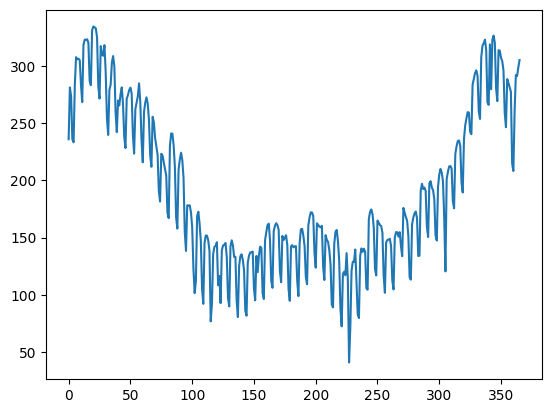

In [308]:
plt.plot(resids_plus_forc)

In [309]:
y_hat_new = resids_plus_forc
y_old = df['Consumption'][-366:].values
sum(2 * np.abs((y_hat_new - y_old)) / (np.abs(y_hat_new) + np.abs(y_old))) * 100 / 366

7.801769543466083